In [1]:
import numpy as np
from scipy.stats import binom, norm
import matplotlib.pyplot as plt

**Problem Statement**

* For a given overbooking policy identify the optimal pricing strategy for a year of flight prices. 
* Each day price can be set as high or low for both coach and first class. Based on the maximum expected value, best policy will be identify the prices to be set for coach and first class tickets

**Probabilities and cost information**

* Probabilities for selling a ticket as well as probability of traveller showing up during the day of the flight as mentioned in the problem statement. 
* Also, the revenue obtained from selling a seat in both coach and first class based on different pricing policy for the day. 

In [2]:
# known variables
n_days = 365
coach_seats = 100
first_seats = 20

prices = {'c': {'l': 300, 'h':350}, 'f':{'l': 425, 'h':500}}
overbooking_cost = {'c': 50, 'f': 425}

showup_probs = {'c': 0.95, 'f': 0.97}
sell_probs = {'c':{'l': 0.65, 'h': 0.3}, 'f':{'l': 0.08, 'h':0.04}}

disc_yr = 0.15
disc_daily = 1/(1+disc_yr/365)

**Estimation of cost on the day of the flight**

Since there is no revenue from selling the tickets during the day of the flight, there will be only cost associated with overbookin in coach and first class.
Negative of expected cost will be calculated for value function on the last day for all possible values of tickets sold in coach and first class

In [3]:
def last_day_cost(c, f, overbooking_cost, showup_probs, coach_seats=100, first_seats=20):
    # creating joint probability and joint cost
    cost_arr = np.zeros((c+1, f+1))
    prob_arr = np.zeros((c+1, f+1))
    
    for i in range(cost_arr.shape[0]):
        for j in range(cost_arr.shape[1]):
            # getting probabilities
            prob_arr[i, j] =  binom.pmf(i, c, showup_probs['c']) * binom.pmf(j, f, showup_probs['f'])
            
            if (i < coach_seats) & (j < first_seats):
                cost_arr[i, j] = 0
            elif (i < coach_seats) & (j >= first_seats):
                kick_f = j - first_seats
                cost_arr[i, j] = kick_f*overbooking_cost['f']
            elif (i >= coach_seats) & (j < first_seats):
                transfer_c = min(first_seats-j, i-coach_seats)
                kick_c = max(0, i-coach_seats-transfer_c)
                cost_arr[i, j] = transfer_c * overbooking_cost['c'] + kick_c * overbooking_cost['f']
                # print(transfer_f, kick_c)
            else:
                kick_c = max(0, i-coach_seats) 
                kick_f = max(0, j-first_seats)
                cost_arr[i, j] = kick_c * overbooking_cost['f'] + kick_f * overbooking_cost['f']
                # print(kick_c, kick_f)
            # print(cost_arr[i, j])
            
    total_cost = np.sum(np.multiply(cost_arr, prob_arr))
    
    return total_cost #, cost_arr, prob_arr

**Expected revenue for the day and value function**

Function defined to - 
1. calculate the expected revenue from the sale of tickets in both class
2. calculate the discounted value function from tomorrow

In [4]:
# expected revenue
# given the price of coach and first class, calculating the expected revenue based on
# probability of sale
def exp_rev(c, f, cp, fp, V, prices, sell_probs):
    rev = 0
    if (c == V.shape[0] - 1) & (f == V.shape[1] - 1):
        rev = 0
    elif (c == V.shape[0] - 1) & (f < V.shape[1] - 1):
        rev = (
            prices['f'][fp] * sell_probs['f'][fp] + 
            0 * (1 - sell_probs['f'][fp])
        )
    elif (c < V.shape[0] - 1) & (f == V.shape[1] - 1):
        rev = (
            prices['c'][cp] * sell_probs['c'][cp] + 
            0 * (1 - sell_probs['c'][cp])
        )
    else:
        rev = (
            (prices['c'][cp] + prices['f'][fp]) * sell_probs['c'][cp] * sell_probs['f'][fp] + 
            prices['c'][cp] * sell_probs['c'][cp] * (1 - sell_probs['f'][fp]) + 
            prices['f'][fp] * (1 - sell_probs['c'][cp]) * sell_probs['f'][fp] + 
            0 * (1 - sell_probs['c'][cp]) * (1 - sell_probs['f'][fp])
            )
    
    return rev

In [5]:
def exp_value_fn(c, f, t, cp, fp, V, sell_probs):
    
    if (c == V.shape[0]-1) & (f == V.shape[1]-1):
        value_fn = V[c, f, t+1]
    elif (c == V.shape[0]-1) & (f < V.shape[1] - 1):
        value_fn = (
            V[c, f+1, t+1] * sell_probs['f'][fp] +
            V[c, f, t+1] * (1 - sell_probs['f'][fp])
        )
    elif (c < V.shape[0]-1) & (f == V.shape[1] - 1):
        value_fn = (
            V[c+1, f, t+1] * sell_probs['c'][cp] +
            V[c, f, t+1] * (1 - sell_probs['c'][cp])
        )
    else:
        value_fn = (
            V[c+1, f+1, t+1] * sell_probs['c'][cp] * sell_probs['f'][fp] +
            V[c+1, f, t+1] * sell_probs['c'][cp] * (1 - sell_probs['f'][fp]) + 
            V[c, f+1, t+1] * (1 - sell_probs['c'][cp]) * sell_probs['f'][fp] +
            V[c, f, t+1] * (1 - sell_probs['c'][cp]) * (1 - sell_probs['f'][fp])
        )
    return value_fn

**Initializing value and state matrix**

Creating value function and state matrix (optimal policy matrix), and populating the value function (negative cost) for the day of the flight

In [6]:
coach_overbooked = 5
first_overbooked = 0

def value_state_init(coach_overbooked, first_overbooked, overbooking_cost, showup_probs,
                     coach_seats=100, first_seats=20, n_days=365):
    dim = (coach_seats+coach_overbooked+1, first_seats+first_overbooked+1, n_days+1)
    V = np.zeros(dim)
    U = np.zeros(dim)
    
    # last day value functions
    for c in range(V.shape[0]):
        for f in range(V.shape[1]):
            V[c, f, -1] = - last_day_cost(c, f, overbooking_cost, showup_probs)
    
    return V, U

**Dynamics with Bellman equation to get optimal policy for each state**

In [7]:
def bellman_dynamic_value_fn(V, U, sell_probs, prices):
    price_choices = [('h', 'h'), ('h', 'l'), ('l', 'h'), ('l', 'l')]

    for t in reversed(range(V.shape[2]-1)):
        for c in range(V.shape[0]):
            for f in range(V.shape[1]):
                rev_choice = np.array(
                    [exp_rev(c, f, cp, fp, V, prices, sell_probs) for cp, fp in price_choices])

                value_fn_choice = np.array(
                    [exp_value_fn(c, f, t, cp, fp, V, sell_probs) for cp, fp in price_choices])

                total_value = rev_choice + disc_daily*value_fn_choice

                V[c, f, t] = np.max(total_value)
                U[c, f, t] = np.argmax(total_value)
    
    return V, U
    

In [8]:
V_init, U_init = value_state_init(coach_overbooked, first_overbooked, overbooking_cost, showup_probs)

In [9]:
V_matrix, U_matrix = bellman_dynamic_value_fn(V_init, U_init, sell_probs, prices)
discounted_value = V_matrix[0, 0, 0]
print('Expected discounted revenue with coach overbooked by', coach_overbooked, 'seats is', V_matrix[0, 0, 0])

Expected discounted revenue with coach overbooked by 5 seats is 42242.86219879489


**Varied overbooking for coach - 5 - 15 seats**

In [10]:
coach_overbooked_list = range(5, 16)
discounted_value_list = []
first_overbooked = 0
V_list = []
U_list = []

for coach_overbooked in coach_overbooked_list:
    print('Getting discounted value for overbooking coach seats of ', coach_overbooked) 
    V_init, U_init = value_state_init(coach_overbooked, first_overbooked, overbooking_cost, showup_probs)
    V, U = bellman_dynamic_value_fn(V_init, U_init, sell_probs, prices)
    V_list.append(V)
    U_list.append(U)
    discounted_value_list.append(V[0, 0, 0])

Getting discounted value for overbooking coach seats of  5
Getting discounted value for overbooking coach seats of  6
Getting discounted value for overbooking coach seats of  7
Getting discounted value for overbooking coach seats of  8
Getting discounted value for overbooking coach seats of  9
Getting discounted value for overbooking coach seats of  10
Getting discounted value for overbooking coach seats of  11
Getting discounted value for overbooking coach seats of  12
Getting discounted value for overbooking coach seats of  13
Getting discounted value for overbooking coach seats of  14
Getting discounted value for overbooking coach seats of  15


The optimal overbooking value is  9 with expected profit as 42496.112304378585


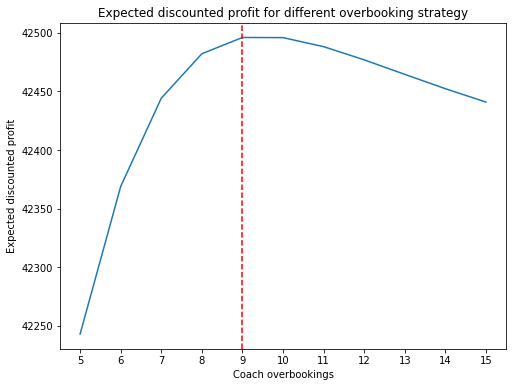

In [11]:
plt.figure(figsize=(8, 6))
plt.plot(coach_overbooked_list, discounted_value_list)
plt.title('Expected discounted profit for different overbooking strategy')
plt.xlabel('Coach overbookings')
plt.ylabel('Expected discounted profit')
plt.xticks(coach_overbooked_list)

optimal_overbooking = coach_overbooked_list[np.argmax(discounted_value_list)]
print('The optimal overbooking value is ', optimal_overbooking, 
      'with expected profit as', np.max(discounted_value_list))

plt.axvline(optimal_overbooking, color='r', ls='--')
plt.show()

**No sale choice for coach**

In [12]:
def bellman_dynamic_nosale_value_fn(V, U, sell_probs, prices):
    price_choices = [('h', 'h'), ('h', 'l'), ('l', 'h'), ('l', 'l'), ('ns', 'h'), ('ns', 'l')]

    for t in reversed(range(V.shape[2]-1)):
        for c in range(V.shape[0]):
            for f in range(V.shape[1]):
                rev_choice = np.array(
                    [exp_rev(c, f, cp, fp, V, prices, sell_probs) for cp, fp in price_choices])

                value_fn_choice = np.array(
                    [exp_value_fn(c, f, t, cp, fp, V, sell_probs) for cp, fp in price_choices])

                total_value = rev_choice + disc_daily*value_fn_choice

                V[c, f, t] = np.max(total_value)
                U[c, f, t] = np.argmax(total_value)
    
    return V, U
    

In [13]:
coach_overbooked = 20
first_overbooked = 0

sell_probs_ns = sell_probs.copy()
sell_probs_ns['c']['ns'] = 0

prices_ns = prices.copy()
prices_ns['c']['ns'] = 0

print('Getting discounted value for overbooking coach seats of ', coach_overbooked)
V, U = value_state_init(coach_overbooked, first_overbooked, overbooking_cost, showup_probs)
V, U = bellman_dynamic_nosale_value_fn(V, U, sell_probs_ns, prices_ns)
discounted_value_no_sale = V[0, 0, 0]

Getting discounted value for overbooking coach seats of  20


In [14]:
discounted_value_no_sale

42502.67326124367

**Policy diagnosis for - 1. Sale for both class each day 2. No sale flexiblity**

Metrics- 
1. % Overbooking - How often is coach overbooked? 
2. High loss overbooking - How often are passengers kicked off the plane? 
3. Overbooking cost per passengar - What is the average overbooking cost? 
4. Change in final profit for each simulation - What is the volatility of discounted profits?

In [15]:
n_iter = 1000

In [16]:
# Sale for both class each day - part 1 
# choosing the best overbooking policy to evaluate
np.random.seed(0)
opt_ob_overbooked_cost_list = np.zeros(n_iter)
opt_ob_transfer_list = np.zeros(n_iter)
opt_ob_kick_list = np.zeros(n_iter)
opt_ob_revenue_list = np.zeros(n_iter)
opt_ob_coach_seats_list = np.zeros(n_iter)
opt_ob_first_seats_list = np.zeros(n_iter)

for i in range(n_iter):
    overbooked_cost = 0
    transfer = 0
    kick = 0
    rev = np.zeros(n_days+1)

    total_coach = optimal_overbooking + coach_seats
    total_first = first_seats

    price_choices = [('h', 'h'), ('h', 'l'), ('l', 'h'), ('l', 'l')]

    c = 0
    f = 0
    V_optimal = V_list[np.argmax(discounted_value_list)]
    U_optimal = U_list[np.argmax(discounted_value_list)]

    # days for selling a ticket
    for t in range(n_days):
        #print(c, f, t)
        idx = int(U_optimal[c, f, t])
        coach_price = price_choices[idx][0]
        first_price = price_choices[idx][1]

        # coach sale
        if c < total_coach:
            coach_sale = np.random.binomial(1, sell_probs['c'][coach_price])
            c += coach_sale
        else:
            coach_sale = 0

        # first sale
        if f < total_first:
            first_sale = np.random.binomial(1, sell_probs['f'][first_price])
            f += first_sale
        else:
            first_sale = 0

        rev[t] = disc_daily**t * (
            prices['c'][coach_price]*coach_sale + 
            prices['f'][first_price]*first_sale)

    
    showup_c = np.random.binomial(c, showup_probs['c'])
    showup_f = np.random.binomial(f, showup_probs['f'])
    
    assert (showup_c <= c) & (showup_f <= f)
    
    # getting performance metrics
    if (showup_c < coach_seats) & (showup_f < first_seats):
        transfer_c, kick_f, kick_c = 0, 0, 0
        cost = 0
        
    if (showup_c < coach_seats) & (showup_f >= first_seats):
        kick_f = showup_f - first_seats
        transfer_c, kick_c = 0, 0
        cost = kick_f*overbooking_cost['f']
        
    elif (showup_c >= coach_seats) & (showup_f < first_seats):
        transfer_c = min(first_seats-showup_f, showup_c-coach_seats)
        kick_c = max(0, showup_c-coach_seats-transfer_c)
        kick_f = 0
        cost = transfer_c * overbooking_cost['c'] + kick_c * overbooking_cost['f']
        
    else:
        kick_c = max(0, showup_c-coach_seats) 
        kick_f = max(0, showup_f-first_seats)
        transfer_c = 0
        cost = kick_c * overbooking_cost['f'] + kick_f * overbooking_cost['f']
    
    kick = kick_c + kick_f
    assert kick >= 0
    opt_ob_kick_list[i] = kick
    # rev[t+1] = disc_daily**(t+1) * V_optimal[c, f, t+1]
    rev[t+1] = -disc_daily**(t+1) * cost
    opt_ob_overbooked_cost_list[i] = cost
    opt_ob_transfer_list[i] = transfer_c
    opt_ob_revenue_list[i] = np.sum(rev)
    opt_ob_coach_seats_list[i] = c
    opt_ob_first_seats_list[i] = f

    

In [17]:
# no sale flexibility for coach booking
np.random.seed(0)
ns_flex_overbooked_cost_list = np.zeros(n_iter)
ns_flex_transfer_list = np.zeros(n_iter)
ns_flex_kick_list = np.zeros(n_iter)
ns_flex_revenue_list = np.zeros(n_iter)
ns_flex_coach_seats_list = np.zeros(n_iter)
ns_flex_first_seats_list = np.zeros(n_iter)

for i in range(n_iter):
    overbooked_cost = 0
    transfer = 0
    kick = 0
    rev = np.zeros(n_days+1)

    total_coach = coach_overbooked + coach_seats
    total_first = first_seats

    price_choices = [('h', 'h'), ('h', 'l'), ('l', 'h'), ('l', 'l'), ('ns', 'h'), ('ns', 'l')]

    c = 0
    f = 0

    # days for selling a ticket
    for t in range(n_days):
        #print(c, f, t)
        idx = int(U[c, f, t])
        coach_price = price_choices[idx][0]
        first_price = price_choices[idx][1]

        # coach sale
        if c < total_coach:
            coach_sale = np.random.binomial(1, sell_probs['c'][coach_price])
            c += coach_sale
        else:
            coach_sale = 0

        # first sale
        if f < total_first:
            first_sale = np.random.binomial(1, sell_probs['f'][first_price])
            f += first_sale
        else:
            first_sale = 0

        rev[t] = disc_daily**t * (
            prices['c'][coach_price]*coach_sale + 
            prices['f'][first_price]*first_sale)
    
    showup_c = np.random.binomial(c, showup_probs['c'])
    showup_f = np.random.binomial(f, showup_probs['f'])
    
    assert (showup_c <= c) & (showup_f <= f)
    
    # getting performance metrics
    if (showup_c < coach_seats) & (showup_f < first_seats):
        transfer_c, kick_f, kick_c = 0, 0, 0
        cost = 0
        
    if (showup_c < coach_seats) & (showup_f >= first_seats):
        kick_f = showup_f - first_seats
        transfer_c, kick_c = 0, 0
        cost = kick_f*overbooking_cost['f']
        
    elif (showup_c >= coach_seats) & (showup_f < first_seats):
        transfer_c = min(first_seats-showup_f, showup_c-coach_seats)
        kick_c = max(0, showup_c-coach_seats-transfer_c)
        kick_f = 0
        cost = transfer_c * overbooking_cost['c'] + kick_c * overbooking_cost['f']
        
    else:
        kick_c = max(0, showup_c-coach_seats) 
        kick_f = max(0, showup_f-first_seats)
        transfer_c = 0
        cost = kick_c * overbooking_cost['f'] + kick_f * overbooking_cost['f']
    
    kick = kick_c + kick_f
    assert kick >= 0
    # storing the metrics
    rev[t+1] = -disc_daily**(t+1) * cost
    ns_flex_overbooked_cost_list[i] = cost
    ns_flex_kick_list[i] = kick
    ns_flex_transfer_list[i] = transfer_c
    ns_flex_revenue_list[i] = np.sum(rev)
    ns_flex_coach_seats_list[i] = c
    ns_flex_first_seats_list[i] = f

    

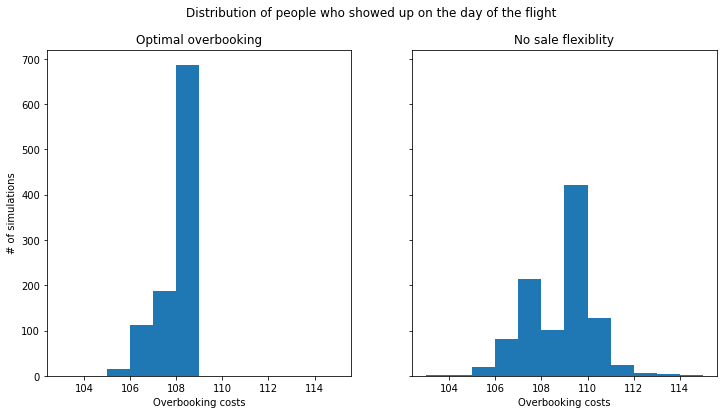

In [18]:
# plotting number of people showing up
fig, axs = plt.subplots(1, 2, figsize = (12, 6), sharey=True, sharex=True)
fig.suptitle('Distribution of people who showed up on the day of the flight')
axs[0].hist(opt_ob_coach_seats_list, bins=np.unique(opt_ob_coach_seats_list))
# axs[0].axvline(coach_seats, color='r', ls='--')
axs[0].set_ylabel('# of simulations')
axs[0].set_xlabel('Overbooking costs')
axs[0].set_title('Optimal overbooking')
axs[1].hist(ns_flex_coach_seats_list, bins=np.unique(ns_flex_coach_seats_list))
axs[1].set_xlabel('Overbooking costs')
axs[1].set_title('No sale flexiblity')
plt.show()

In optimal overbooking strategy probability of passengers getting overbooked is 1.0
In no sale flexibility strategy probability of passengers getting overbooked is 1.0


<BarContainer object of 2 artists>

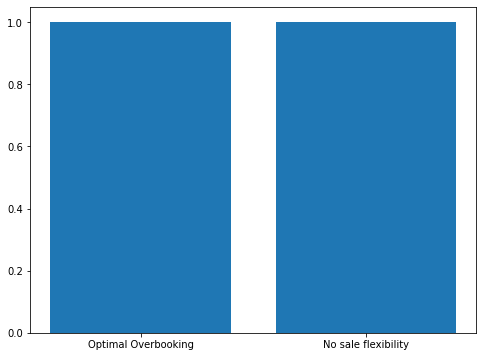

In [19]:
# % overbooking
opt_ob_ob_per = sum(opt_ob_coach_seats_list != 0)/len(opt_ob_overbooked_cost_list)
ns_flex_ob_per = sum(ns_flex_coach_seats_list != 0)/len(ns_flex_coach_seats_list)
print('In optimal overbooking strategy probability of passengers getting overbooked is', opt_ob_ob_per)
print('In no sale flexibility strategy probability of passengers getting overbooked is', ns_flex_ob_per)

plt.figure(figsize=(8, 6))
plt.bar(['Optimal Overbooking', 'No sale flexibility'], height=[opt_ob_ob_per, ns_flex_ob_per])

In optimal overbooking strategy probability of passengers getting transferred or kicked is 0.813
In no sale flexibility strategy probability of passengers getting transferred or kicked is 0.82


<BarContainer object of 2 artists>

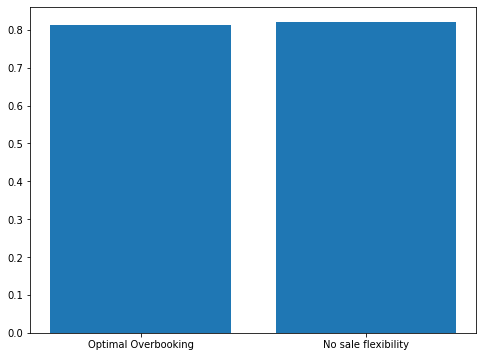

In [20]:
# % overbooking
opt_ob_obk_per = sum(opt_ob_overbooked_cost_list != 0)/len(opt_ob_overbooked_cost_list)
ns_flex_obk_per = sum(ns_flex_overbooked_cost_list != 0)/len(ns_flex_overbooked_cost_list)
print('In optimal overbooking strategy probability of passengers getting transferred or kicked is', opt_ob_obk_per)
print('In no sale flexibility strategy probability of passengers getting transferred or kicked is', ns_flex_obk_per)

plt.figure(figsize=(8, 6))
plt.bar(['Optimal Overbooking', 'No sale flexibility'], height=[opt_ob_obk_per, ns_flex_obk_per])

In optimal overbooking strategy probability of passengers getting kicked off is 0.695
In no sale flexibility strategy probability of passengers getting kicked off is 0.705


<BarContainer object of 2 artists>

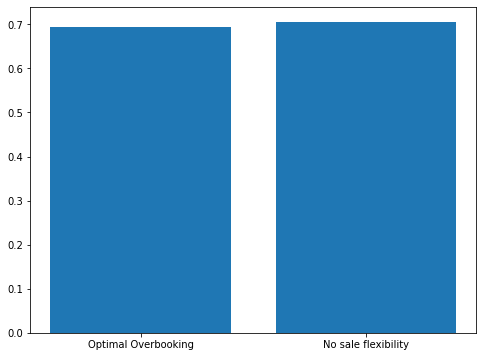

In [21]:
# kicked off
opt_ob_kick_per = sum(opt_ob_kick_list != 0)/len(opt_ob_kick_list)
ns_flex_kick_per = sum(ns_flex_kick_list != 0)/len(ns_flex_kick_list)
print('In optimal overbooking strategy probability of passengers getting kicked off is', opt_ob_kick_per)
print('In no sale flexibility strategy probability of passengers getting kicked off is', ns_flex_kick_per)

plt.figure(figsize=(8, 6))
plt.bar(['Optimal Overbooking', 'No sale flexibility'], height=[opt_ob_kick_per, ns_flex_kick_per])

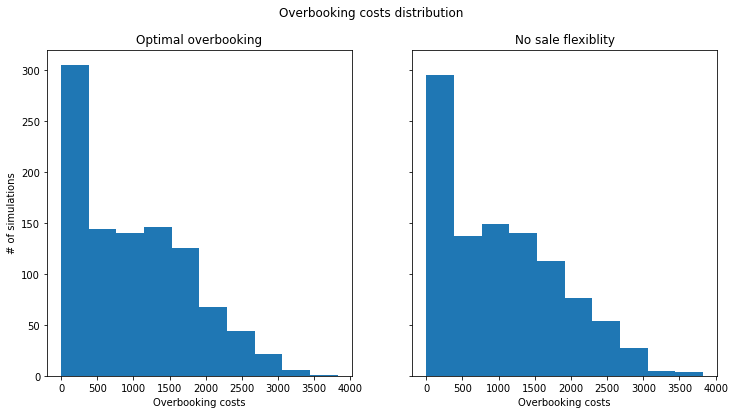

Average overbooking cost for Optimal overbooking is  961.82
Average overbooking cost for No sale flexiblity is  1004.82


In [22]:
# overbooking cost per passenger
# NO SALE FLEXIBLITY HAVE HIGHER OVERBOOKING COSTS
fig, axs = plt.subplots(1, 2, figsize = (12, 6), sharey=True)
fig.suptitle('Overbooking costs distribution')
axs[0].hist(opt_ob_overbooked_cost_list)
axs[0].set_ylabel('# of simulations')
axs[0].set_xlabel('Overbooking costs')
axs[0].set_title('Optimal overbooking')
axs[1].hist(ns_flex_overbooked_cost_list)
axs[1].set_xlabel('Overbooking costs')
axs[1].set_title('No sale flexiblity')
plt.show()

print('Average overbooking cost for Optimal overbooking is ', np.round(np.mean(opt_ob_overbooked_cost_list), 2))
print('Average overbooking cost for No sale flexiblity is ', np.round(np.mean(ns_flex_overbooked_cost_list), 2))

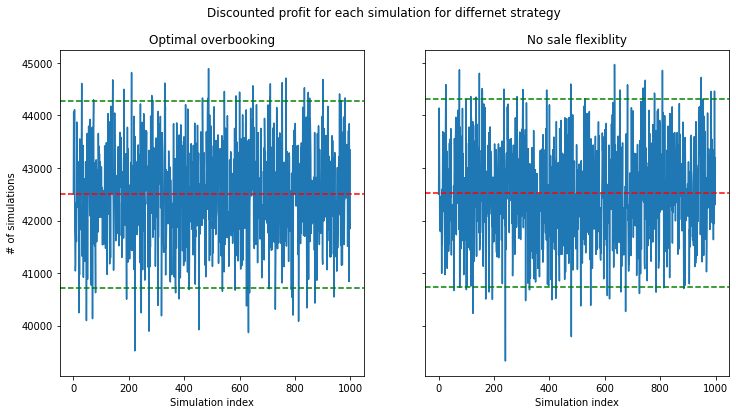

Discounted profit volatility of Optimal overbooking strategy is  0.02134862097023756
Discounted profit volatility of No sale flexiblity strategy is  0.021452838381510703


In [23]:
# profit volatility
fig, axs = plt.subplots(1, 2, figsize = (12, 6), sharey=True, sharex=True)
fig.suptitle('Discounted profit for each simulation for differnet strategy')
axs[0].plot(opt_ob_revenue_list)
axs[0].set_ylabel('# of simulations')
axs[0].set_xlabel('Simulation index')
axs[0].set_title('Optimal overbooking')
opt_ob_mean_rev, opt_ob_std_rev = np.mean(opt_ob_revenue_list), np.std(opt_ob_revenue_list)
z_val = norm.ppf(0.975)
axs[0].axhline(opt_ob_mean_rev, color='r', ls='--')
axs[0].axhline(opt_ob_mean_rev - z_val*opt_ob_std_rev, color='g', ls='--')
axs[0].axhline(opt_ob_mean_rev + z_val*opt_ob_std_rev, color='g', ls='--')

axs[1].plot(ns_flex_revenue_list)
axs[1].set_xlabel('Simulation index')
axs[1].set_title('No sale flexiblity')
ns_flex_mean_rev, ns_flex_std_rev = np.mean(ns_flex_revenue_list), np.std(ns_flex_revenue_list)
z_val = norm.ppf(0.975)
axs[1].axhline(ns_flex_mean_rev, color='r', ls='--')
axs[1].axhline(ns_flex_mean_rev - z_val*ns_flex_std_rev, color='g', ls='--')
axs[1].axhline(ns_flex_mean_rev + z_val*ns_flex_std_rev, color='g', ls='--')
plt.show()

opt_ob_cov = opt_ob_std_rev/opt_ob_mean_rev
ns_flex_cov = ns_flex_std_rev/ns_flex_mean_rev
print('Discounted profit volatility of Optimal overbooking strategy is ', opt_ob_cov)
print('Discounted profit volatility of No sale flexiblity strategy is ', ns_flex_cov)

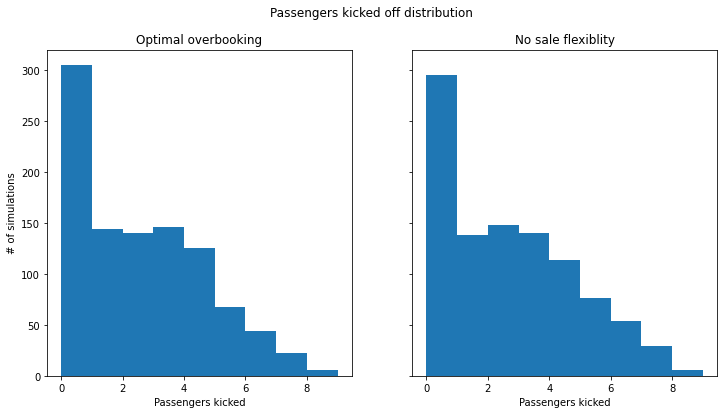

Average passengers kicked for Optimal overbooking is  2.17
Average passengers kicked for No sale flexiblity is  2.27


In [24]:
# passengers getting kicked
fig, axs = plt.subplots(1, 2, figsize = (12, 6), sharey=True)
fig.suptitle('Passengers kicked off distribution')
axs[0].hist(opt_ob_kick_list, bins=np.unique(opt_ob_kick_list))
axs[0].set_ylabel('# of simulations')
axs[0].set_xlabel('Passengers kicked')
axs[0].set_title('Optimal overbooking')
axs[1].hist(ns_flex_kick_list, bins=np.unique(ns_flex_kick_list))
axs[1].set_xlabel('Passengers kicked')
axs[1].set_title('No sale flexiblity')
plt.show()

print('Average passengers kicked for Optimal overbooking is ', np.round(np.mean(opt_ob_kick_list), 2))
print('Average passengers kicked for No sale flexiblity is ', np.round(np.mean(ns_flex_kick_list), 2))

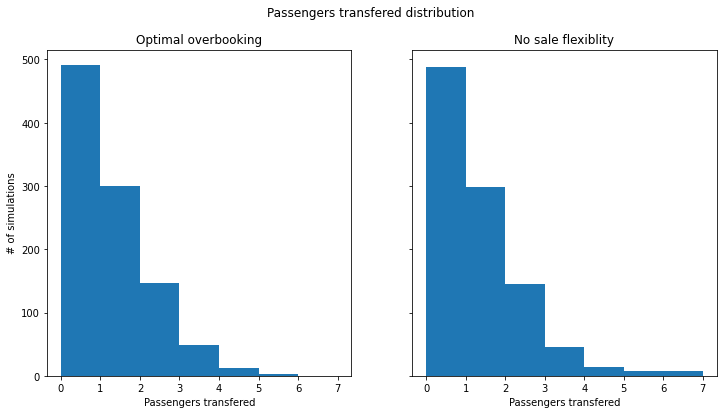

Average passengers transferred for Optimal overbooking is  0.8
verage passengers transferred for No sale flexiblity is  0.83


In [25]:
# passengers getting transfered
fig, axs = plt.subplots(1, 2, figsize = (12, 6), sharey=True, sharex=True)
fig.suptitle('Passengers transfered distribution')
axs[0].hist(opt_ob_transfer_list, bins=np.unique(opt_ob_transfer_list))
axs[0].set_ylabel('# of simulations')
axs[0].set_xlabel('Passengers transfered')
axs[0].set_title('Optimal overbooking')
axs[1].hist(ns_flex_transfer_list, bins=np.unique(ns_flex_transfer_list))
axs[1].set_xlabel('Passengers transfered')
axs[1].set_title('No sale flexiblity')
plt.show()

print('Average passengers transferred for Optimal overbooking is ', np.round(np.mean(opt_ob_transfer_list), 2))
print('verage passengers transferred for No sale flexiblity is ', np.round(np.mean(ns_flex_transfer_list), 2))